# Notebook for testing Halomodel functions by comparing with CCL

In [2]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from helpers_plot import initPlot, finalizePlot
initPlot()

# Set Cosmology and basics

In [3]:
# Cosmology setting
h=0.73
cosmo=ccl.Cosmology(Omega_c=0.205, Omega_b=0.045, h=h, n_s=1, sigma8=0.9)

In [4]:
# Set Mass Def and concentration
hmd_200m=ccl.halos.MassDef200m()
cM=ccl.halos.ConcentrationDuffy08(hmd_200m)

In [5]:
# Set redshift and halo mass
z=1
a=1/(1+z)
m=1e14/h # in Msun

# Check NFW

In [36]:
# Create NFW from ccl
k_arr=np.geomspace(1e-2, 1e2, 128)
profile=ccl.halos.HaloProfileNFW(cM, truncated=True)
u=profile.fourier(cosmo, k_arr, m, a, mass_def=hmd_200m)/m

In [37]:
# Load from file
u_myCode=np.loadtxt("../scripts/test_halomodel/u_nfw_threepointCode.dat")

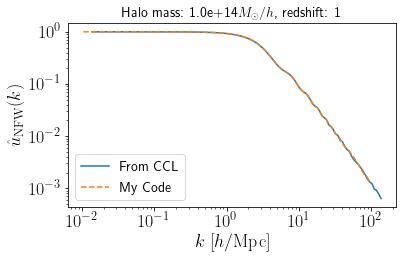

In [38]:
# Do Plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ $[h/\mathrm{Mpc}]$")
plt.ylabel(r"$u_\mathrm{NFW}(k)$")
plt.plot(k_arr, u, label='From CCL')
plt.plot(u_myCode[:,0], u_myCode[:,1], label='My Code')
plt.legend()
plt.show()

# Check HMF

In [9]:
# Create HMF from ccl
m_arr=np.geomspace(1e10, 1e16, 128)
hmf=ccl.halos.MassFuncSheth99(cosmo)
dndlogm=hmf.get_mass_function(cosmo, m_arr, a) # dn/dlog10(m) [1/Mpc³]
dndm=dndlogm/m_arr/np.log(10) #dn/dm [1/Msun/Mpc³]
m_arr_h=m_arr*h #m [Msun h^-1]
dndm_h=dndm/np.power(h,4) # dn/dm [h⁴/Msun/Mpc³]

In [10]:
# Read from file
hmf_myCode=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/HMF.dat")

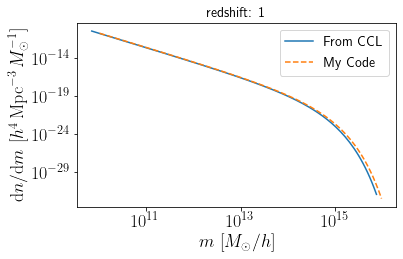

In [40]:
# Do Plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$m$ $[M_{\odot}/h]$")
plt.ylabel(r"$dn/dm$ $[h^4\, \mathrm{Mpc}^{-3}\, M_{\odot}^{-1}]$")
plt.plot(m_arr_h, dndm_h, label='From CCL')
plt.plot(hmf_myCode[:,0], hmf_myCode[:,1], label='My Code')
plt.legend()
plt.show()

# Check Powerspec

In [14]:
# Read in Powerspec of MS (1-halo term) from my code

powerspec_mycode=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/Powerspec_halomodel")
powerspec_halofit=np.loadtxt("../necessary_files/p_ell_MS.dat")

In [15]:
# Calculate 1 halo term from CCL

z_arr=np.linspace(0, 1.0, 100)
nz_arr=np.zeros(100)
nz_arr[99]=1
k_arr = np.geomspace(1e-4,1e3,256)
a_arr=np.linspace(0.1, 1, 64)
l_arr=np.geomspace(10, 1e5, 256)

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()
hmd_fof = ccl.halos.MassDef('fof', 'matter')
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM, truncated=True)
hmc = ccl.halos.HMCalculator(cosmo, nM, bM,  hmd_200m)

t_M = ccl.WeakLensingTracer(cosmo, (z_arr, nz_arr))

pk_MMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                normprof1=True, get_2h=False, get_1h=True,
                                lk_arr=np.log(k_arr), a_arr=a_arr)

cl_MM=ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf)

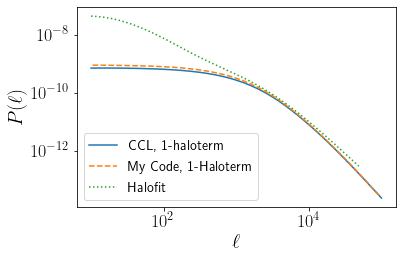

In [43]:

# Plots
fig, ax=plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
#plt.plot(powerspec_mycode[:,0], powerspec_mycode[:,1]*0.7, label='My Code, 1-Haloterm x0.7')

ax.plot(l_arr, cl_MM, label='CCL, 1-haloterm')
ax.plot(powerspec_mycode[:,0], powerspec_mycode[:,1], ls='--', label='My Code, 1-Haloterm')
ax.plot(powerspec_halofit[:,0], powerspec_halofit[:,1], ls=':', label='Halofit')
ax.set_xlabel(r'$\ell$', size=20)
ax.set_ylabel(r'$P(\ell)$', size=20)

finalizePlot(ax, outputFn="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/Powerspec.pdf")


# Check Trispectrum 1 Halo Term

In [45]:
# Calculate Trispectrum 1 halo term from CCL
k_arr = np.geomspace(1e-3,1e5,100)
a_arr=[0.5]#np.linspace(0.1, 1, 32)


# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()
hmd_fof = ccl.halos.MassDef('fof', 'matter')
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM, truncated=True)
hmc = ccl.halos.HMCalculator(cosmo, nM, bM,  hmd_200m)


tri1h = ccl.halos.halo_model.halomod_trispectrum_1h(cosmo, hmc, k_arr, a_arr, pM, normprof1=True)



In [46]:
# Load 3D Trispec from file
trispec_halomodel=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/Trispec3D_halomodel")


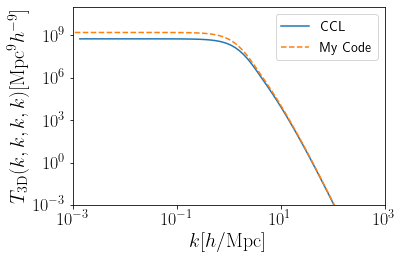

In [47]:
fig, ax=plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e11)
ax.set_xlim(1e-3, 1e3)

ax.set_xlabel(r'$k [h/\mathrm{Mpc}]$', size=20)
ax.set_ylabel(r'$T_\mathrm{3D}(k, k, k, k) [\mathrm{Mpc}^9 h^{-9}]$', size=20)

ax.plot(k_arr/h, np.diag(tri1h[0])*h**9, label="CCL")
ax.plot(trispec_halomodel[:,0], trispec_halomodel[:,1], ls='--', label="My Code")

finalizePlot(ax, outputFn="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/Trispec3D.pdf")

In [48]:
def W(z, cosmo):
    chi=cosmo.comoving_radial_distance(1./(1.+z))
    chi_prime=cosmo.comoving_radial_distance(0.5)
    res=3*cosmo['h']**2*cosmo['Omega_m']/2/2998/2998*chi*(1+z)*(chi_prime-chi)/chi_prime
    return res 

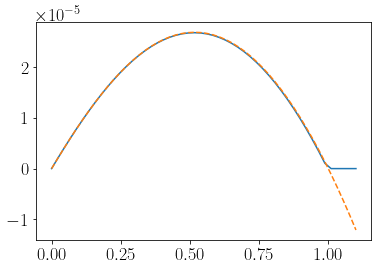

In [62]:
z_arr=np.linspace(0, 1.1)
a_arr=1/(1+z_arr)
chi_arr=cosmo.comoving_radial_distance(a_arr)

q=t_M.get_kernel(chi_arr)[0]
w=W(z_arr, cosmo)

plt.plot(z_arr, q)
plt.plot(z_arr, w, ls='--')

In [101]:
def int_T(z, l, cosmo, halomodcalculator, profile, tracer):
    #W_=W(z, cosmo)
    a=1./(1.+z)
    chi=cosmo.comoving_radial_distance(a)
    W_=tracer.get_kernel(chi)[0]
    T_3d=ccl.halos.halo_model.halomod_trispectrum_1h(cosmo, halomodcalculator, l/chi, a, profile, normprof1=True)
    res=2998/cosmo['h']/cosmo.h_over_h0(a)/chi**6*W_**4*T_3d
    return res

In [102]:
# Calculate 2D Trispec
ls=np.geomspace(150, 40000, 15)

T_ccl=[]
for l in ls:
    res, err=quad(int_T, 0, 1.1, args=(l, cosmo, hmc, pM, t_M))
    T_ccl.append(res)

T_ccl=np.array(T_ccl)

In [65]:
# Load from file
trispec_halomodel_2D=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/Trispec_halomodel2")

In [66]:
# Load Trispec measurement
trispec_MS=[]
for i in range(64):
    dat=np.loadtxt(f"/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/trispectra/trispectrum_equilateral_los_{i}.dat", dtype=np.complex)
    ells=dat[:,0]
    trispec_MS.append(dat[:,1])

trispec_MS=np.array(trispec_MS)

/home/laila/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/laila/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:3380: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/laila/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:3386: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


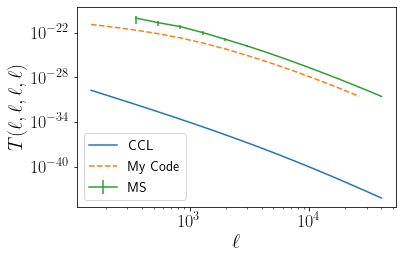

In [103]:
fig, ax=plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(ls, T_ccl, label='CCL')
ax.plot(trispec_halomodel_2D[:,0], trispec_halomodel_2D[:,1], ls='--', label='My Code')
ax.errorbar(ells, np.mean(trispec_MS, axis=0), yerr=np.std(trispec_MS, axis=0), label='MS')
ax.set_xlabel(r'$\ell$', size=20)
ax.set_ylabel(r'$T(\ell, \ell, \ell, \ell)$', size=20)
finalizePlot(ax, outputFn="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/results_MR/Trispec.pdf")